In [1]:
%config ZMQInteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


## 全连接和卷积

- 全连接层参数多，运算量大，也容易过拟合，很难捕捉局部不变性
- 卷积层参数大大减少，共享参数，可以捕捉局部不变性。
    - 卷积层保留输入形状，使得图像的像素在高和宽两个方向上的相关性可以被识别
    - 卷积层通过滑动窗口将同一卷积核与不同的位置输入重复计算，从而避免参数尺寸过大

## LeNet5

总共有7层（3个卷积，2个池化，2个全连接）
- conv1: 1\*28\*28灰度图像（最初论文中其实是1\*32\*32的图像），经过6个5\*5的卷积核(padding为2)，变成了6\*28\*28的输出
    - 可学习参数有6*(5*5+1)=156个，连接数156\*28\*28=122304个
- pool1: 6\*28\*28的卷积层，经过2*2的最大池化，得到6*14*14
    - 可学习参数有6\*(1+1)=12个，连接数6\*(4+1)\*14\*14=5880个
- conv2: 6\*14\*14的最大汇聚层，经过96个5\*5的卷积核，变成16\*10\*10的卷积层
    - 论文中实际上使用连接表，用了60个5\*5的卷积核，先3个连续子集，然后4个连续子集，然后4个不连续子集，最后是所有的子集
    - 可学习参数96\*(5\*5)+16=2416个，连接数为16\*((6\*5\*5+1)\*10\*10)=241600个
- pool2: 16\*10\*10的卷积层经过2*2的最大池化，变成16*5*5的输出
    - 可学习参数为16\*(1+1)=32个，连接数为16\*(4+1)\*5\*5=2000个
- conv3: 16\*5\*5的最大汇聚层，经过1920个5\*5的卷积核，变成120\*1\*1的输出
    - 可学习参数为1920\*5\*5+120=48120，连接数为120\*((16\*5\*5+1)\*1\*1)=48120个
- fc1: 120个神经元经过全连接变成84个神经元
    - 可学习参数和连接数都是120\*84+84=10164个
- fc2: 84个神经元经过全连接变成10个神经元
    - 可学习参数和连接数都是84\*10+10=850个
    
以前，LeNet5（论文中）也会在池化层后加上激活函数，但是现在一般不加

In [42]:
import sys
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.data as Data
from collections import OrderedDict
sys.path.append("../d2l_func/")
from model_train import train_pytorch
from data_prepare import download_data_fashion_mnist, load_data_fashion_mnist

In [59]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view()
    

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.Tanh(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )
        
    def forward(self, x):
        # 出来的是(batch, 120, 1, 1)，要将它变成向量
        output = self.conv(x)
        output = output.view(output.shape[0], -1)
        return self.fc(output)
    
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

Epoch [1/3]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 1.7861, train_score: 0.374, test_loss: 1.7789, test_score: 0.377

Epoch [2/3]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.8546, train_score: 0.684, test_loss: 0.8654, test_score: 0.678

Epoch [3/3]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.6225, train_score: 0.764, test_loss: 0.6408, test_score: 0.755



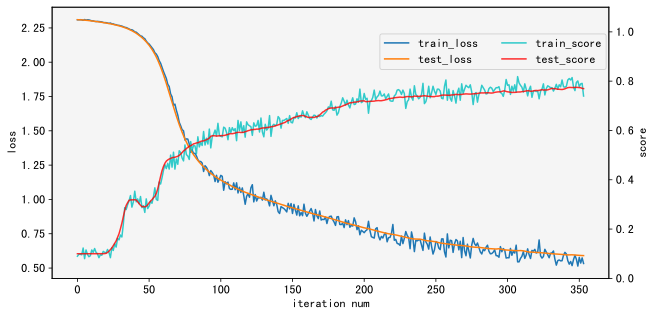

execute time is 80.796 seconds


In [63]:
# define model(change to gpu) and loss
model = LeNet5()
model = model.cuda()
loss = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# load
mnist_train, mnist_test = download_data_fashion_mnist()

params = {
    "epoch_num": 3,
    "data_num": len(mnist_train),
    "batch_size": 512,
    "model": model,
    "loss": loss,
    "optimizer": optimizer,
    "gpu": True,
    "draw": True,
    "test_iter": Data.DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True),
    "evaluate": model.score,
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8)
params["train_iter"] = train_iter

# training
train_pytorch(**params)